In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In real-world data (e.g., psychology experiments), not every decision is made rationally:
People get distracted
They guess
Some responses are just random

By simulating this, we re evaluating how well the DDM handles messy, real-life data — and whether it can still recover the true parameters when the data is "contaminated."

Goal: testing the robustness of DDM by adding noise trials — simulating what happens when:
A participant isn’t paying attention
They randomly guess the answer
Their RT doesn’t follow the normal DDM process

These “noisy” trials are:
Not simulated with DDM
The choice is random
The RT is sampled from a simple uniform distribution, like between 0.3 and 2.5 seconds
These trials are labeled "noise" in the output

### Simulate a single DDM trial

In [3]:
def simulate_ddm_trial(v, a, z=0.5, t0=0.3, sigma=1.0, dt=0.001, max_time=5.0):
    x = z * a
    for step in range(int(max_time / dt)):
        x += v * dt + sigma * np.sqrt(dt) * np.random.randn()
        if x >= a:
            return 1, step * dt + t0
        elif x <= 0:
            return 0, step * dt + t0
    return np.nan, np.nan

### Simulate dataset with optional noise (mind-wandering) trials

In [4]:
def simulate_dataset_with_noise(n_trials, v, a, t0, noise_ratio=0.2, rt_range=(0.3, 2.5)):
    data = []
    n_noise = int(n_trials * noise_ratio)
    n_ddm = n_trials - n_noise

    # Simulate clean DDM trials
    for _ in range(n_ddm):
        choice, rt = simulate_ddm_trial(v, a, t0=t0)
        if not np.isnan(choice):
            data.append({
                "trial_type": "ddm",
                "choice": choice,
                "rt": rt
            })

    # Simulate noise (random guess) trials
    for _ in range(n_noise):
        random_choice = np.random.choice([0, 1])
        random_rt = np.random.uniform(*rt_range)
        data.append({
            "trial_type": "noise",
            "choice": random_choice,
            "rt": random_rt
        })

    return pd.DataFrame(data)

### Run two simulations: clean vs. noisy

In [5]:
clean_data = simulate_dataset_with_noise(n_trials=500, v=0.5, a=1.0, t0=0.3, noise_ratio=0.0)
noisy_data = simulate_dataset_with_noise(n_trials=500, v=0.5, a=1.0, t0=0.3, noise_ratio=0.2)

# Add condition labels
clean_data["condition"] = "clean"
noisy_data["condition"] = "noisy"

# Combine into one DataFrame
combined_df = pd.concat([clean_data, noisy_data], ignore_index=True)

### Save to Excel

In [6]:
combined_df.to_excel("clean_vs_noisy_ddm_data.xlsx", index=False)

# Set the plot style
sns.set(style="whitegrid")

# Create figure and subplots
plt.figure(figsize=(14, 6))

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

### Plot 1: Reaction Time Distribution

Text(0.5, 0, 'Condition')

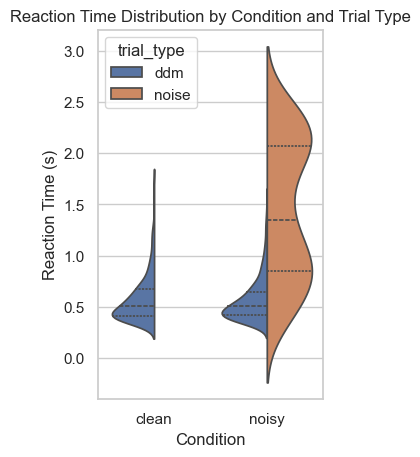

In [7]:
plt.subplot(1, 2, 1)
sns.violinplot(
    data=combined_df,
    x="condition",
    y="rt",
    hue="trial_type",
    split=True,
    inner="quartile"
)
plt.title("Reaction Time Distribution by Condition and Trial Type")
plt.ylabel("Reaction Time (s)")
plt.xlabel("Condition")

### Plot 2: Proportion of Choice = 1

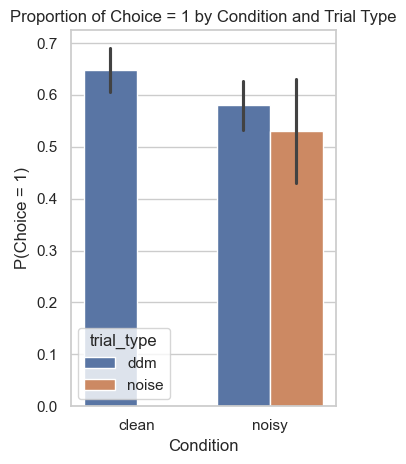

In [8]:
plt.subplot(1, 2, 2)
sns.barplot(
    data=combined_df,
    x="condition",
    y="choice",
    hue="trial_type",
    estimator=np.mean
)
plt.title("Proportion of Choice = 1 by Condition and Trial Type")
plt.ylabel("P(Choice = 1)")
plt.xlabel("Condition")

# Layout and show
plt.tight_layout()
plt.show()

From the results, we can conclude the following:
1.Reaction times in clean DDM trials are more consistent and clustered, reflecting a structured decision-making process guided by evidence accumulation. In contrast, noisy trials introduce greater variability, with reaction times spread more widely and lacking the characteristic shape of DDM-generated distributions.
2.Choice proportions in clean trials show a clear directional bias (e.g., more "1" choices when the drift rate is positive), indicating that decisions are systematically driven by the model’s drift parameter. However, in noisy trials, choice proportions approach 50/50, suggesting that decisions are random and not influenced by accumulated evidence.
3.When noisy (guessing) trials are mixed into the dataset, the overall behavioral patterns (both RT and choice) become distorted. This demonstrates the importance of accounting for non-decision-based responses in real-world data analysis, as they can lead to biased or misleading parameter estimates if not modeled appropriately.
4.The model’s robustness is limited: even a modest proportion of guessing trials (e.g., 20%) noticeably alters the observed data, highlighting the need for models or preprocessing techniques that can detect or accommodate such noise in cognitive modeling studies.
